In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn import model_selection, svm
from sklearn.model_selection import train_test_split
import re
import string
import nltk
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
import spacy

In [ ]:
train = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_train.csv',encoding='latin-1')

In [ ]:
train.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
train['Sentiment'].value_counts()

Positive              11422
Negative               9917
Neutral                7713
Extremely Positive     6624
Extremely Negative     5481
Name: Sentiment, dtype: int64

In [ ]:
test = pd.read_csv('/kaggle/input/covid-19-nlp-text-classification/Corona_NLP_test.csv',encoding='latin-1')

In [ ]:
test.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


# Adding both train and test data in a single DataFrame

In [ ]:
def Combined(df1,df2):
    final_df = pd.concat([df1, df2], axis = 0)
    final_df = final_df.drop(['UserName', 'ScreenName', 'Location', 'TweetAt'], axis = 1)
    final_df['Sentiment'] = final_df['Sentiment'].replace({'Extremely Positive' : 'Positive','Extremely Negative' : 'Negative' })
    final_df['Sentiment'] = final_df['Sentiment'].replace({'Positive' : 0, 'Negative' : 1, 'Neutral' : 2})
    return final_df

In [ ]:
data = Combined(train, test)
data.head()

,OriginalTweet,Sentiment
0,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,2
1,advice Talk to your neighbours family to excha...,0
2,Coronavirus Australia: Woolworths to give elde...,0
3,My food stock is not the only one which is emp...,0
4,"Me, ready to go at supermarket during the #COV...",1


In [ ]:
data.shape

(44955, 2)

In [ ]:
data.isna().sum()

OriginalTweet    0
Sentiment        0
dtype: int64

In [ ]:
data.duplicated().any()

False

In [ ]:
data['OriginalTweet'] = data['OriginalTweet'].apply(lambda x : x.lower())

In [ ]:
pip install contractions


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 287.5/287.5 kB 5.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.5/106.5 kB 7.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import re

In [ ]:
data['OriginalTweet']=data['OriginalTweet'].apply(lambda x: re.sub('\w*\d\w*','', x))

In [ ]:
import contractions
data['OriginalTweet'] = data["OriginalTweet"].apply(lambda x : contractions.fix(x))

## Removing Non-sensical Words

In [ ]:
data['OriginalTweet'] = [re.sub('\n', '', x) for x in data['OriginalTweet']]

In [ ]:
data['OriginalTweet']

0       @menyrbie @phil_gahan @chrisitv https://t.co/ ...
1       advice talk to your neighbours family to excha...
2       coronavirus australia: woolworths to give elde...
3       my food stock is not the only one which is emp...
4       me, ready to go at supermarket during the # ou...
                              ...                        
3793    meanwhile in a supermarket in israel -- people...
3794    did you panic buy a lot of non-perishable item...
3795    asst prof of economics @cconces was on @nbcphi...
3796    gov need to do something is instead of biar je...
3797    i and @forestandpaper members are committed to...
Name: OriginalTweet, Length: 44955, dtype: object

In [ ]:
import string

In [ ]:
data['OriginalTweet'] = data["OriginalTweet"].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))

# Removing Extra Spaces

In [ ]:
data['OriginalTweet'] = data["OriginalTweet"].apply(lambda x: re.sub(' +',' ',x))

In [ ]:
data['OriginalTweet']

0       menyrbie philgahan chrisitv httpstco and https...
1       advice talk to your neighbours family to excha...
2       coronavirus australia woolworths to give elder...
3       my food stock is not the only one which is emp...
4       me ready to go at supermarket during the outbr...
                              ...                        
3793    meanwhile in a supermarket in israel people da...
3794    did you panic buy a lot of nonperishable items...
3795    asst prof of economics cconces was on nbcphila...
3796    gov need to do something is instead of biar je...
3797    i and forestandpaper members are committed to ...
Name: OriginalTweet, Length: 44955, dtype: object

In [ ]:
import spacy

# Loading model
nlp = spacy.load('en_core_web_sm',disable=['parser', 'ner'])

# Lemmatization with stopwords removal
data['Final_text']=data['OriginalTweet'].apply(lambda x: ' '.join([token.lemma_ for token in list(nlp(x)) if (token.is_stop==False)]))

In [ ]:
data['Final_text'] = [re.sub('httpstco', '', x) for x in data['Final_text']]

In [ ]:
data['Final_text']

0                          menyrbie philgahan chrisitv   
1       advice talk neighbour family exchange phone nu...
2       coronavirus australia woolworth elderly disabl...
3       food stock \r\r\r\r panic food need \r\r stay ...
4       ready supermarket outbreak \r\r\r\r paranoid f...
                              ...                        
3793    supermarket israel people dance sing stay posi...
3794    panic buy lot nonperishable item echo need foo...
3795    asst prof economic cconce nbcphiladelphia talk...
3796    gov need instead biar je rakyat assume lockdow...
3797    forestandpaper member commit safety employee e...
Name: Final_text, Length: 44955, dtype: object

# Making word Clouds

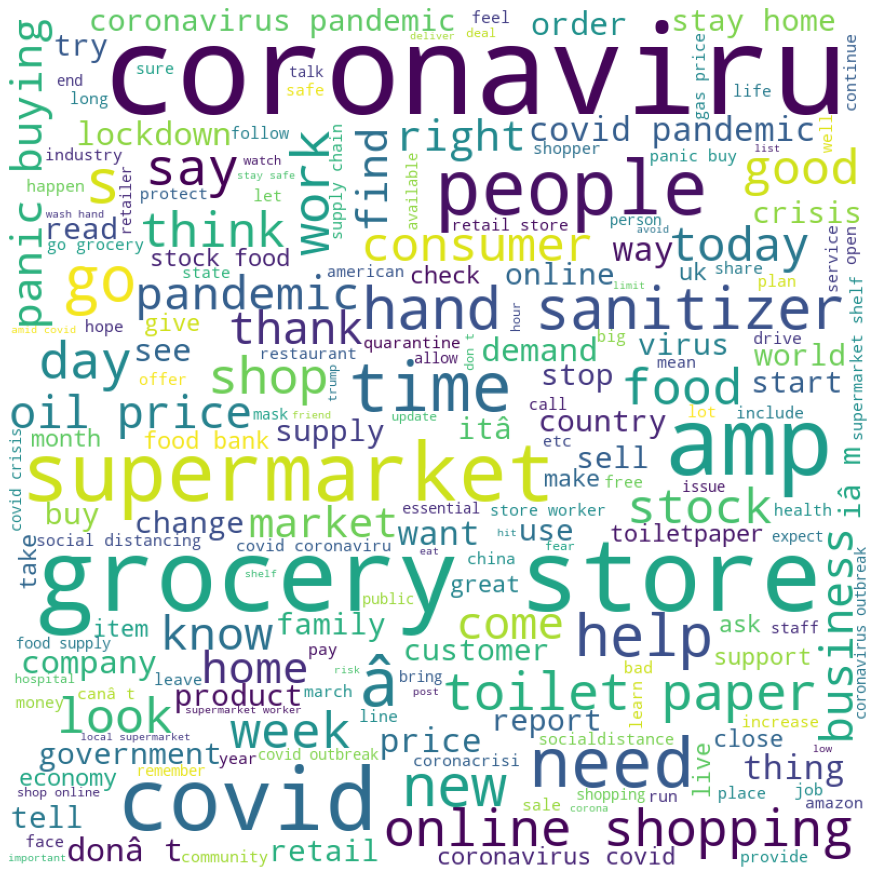

In [ ]:
from wordcloud import WordCloud, STOPWORDS

comment_words = ''

# iterate through the csv file
for val in data['Final_text']:

    # typecaste each val to string
    val = str(val)

    # split the value
    tokens = val.split()

    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()

    comment_words += " ".join(tokens)+" "

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(comment_words)

# plot the WordCloud image
plt.figure(figsize = (12, 12), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

# Pie Chart for Sentiments

# Most Common Words

In [ ]:
most_common_original = Counter(''.join(data['OriginalTweet']).split()).most_common(50)
mco_df = pd.DataFrame(most_common_original, columns = ['Words', 'Freq'])
most_common_final = Counter(''.join(data['Final_text']).split()).most_common(50)
mcf_df = pd.DataFrame(most_common_final, columns = ['Words', 'Freq'])

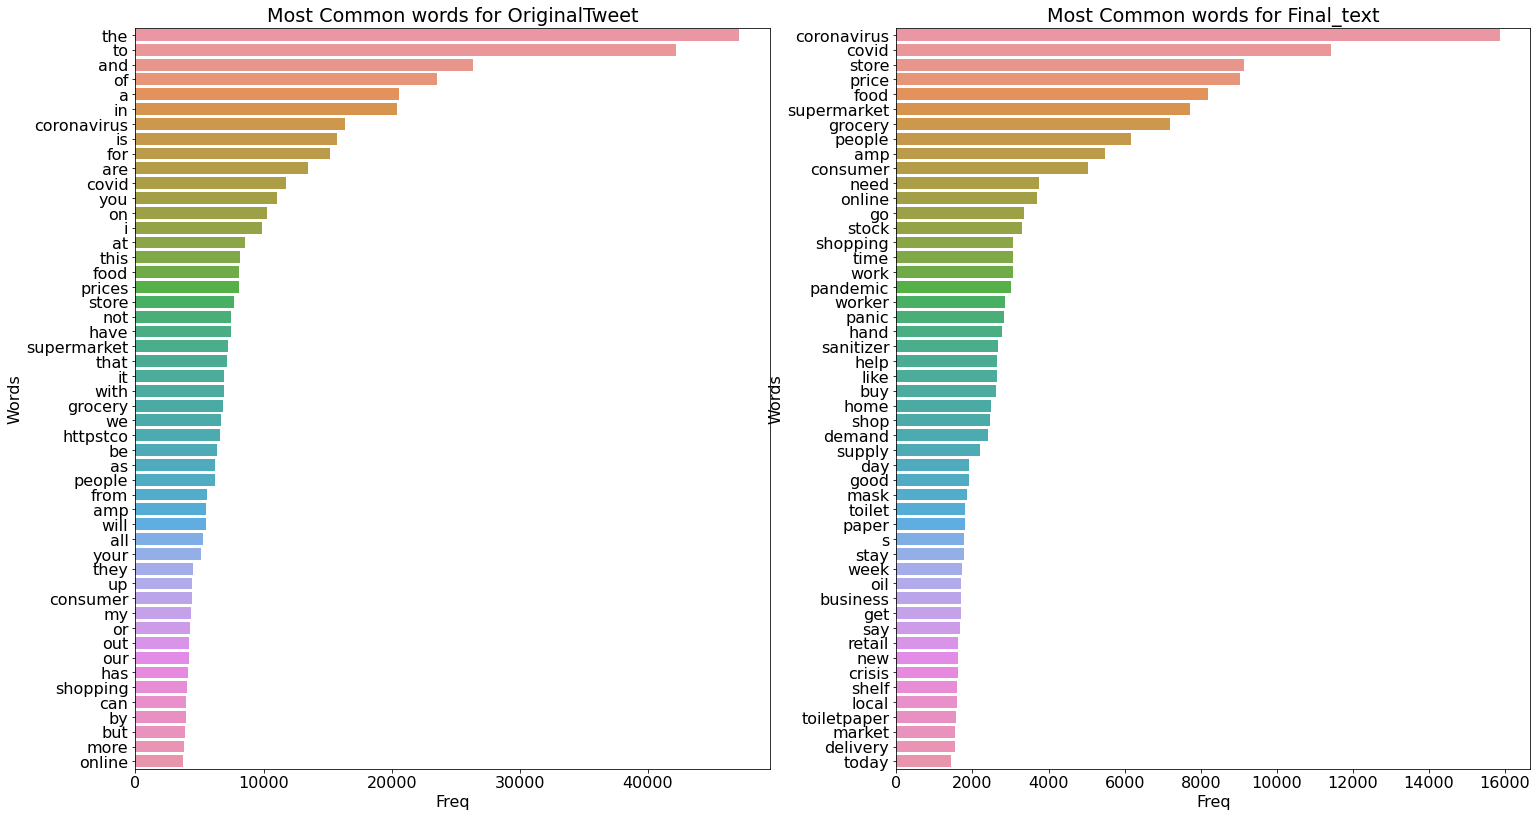

In [ ]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize = (25, 30))
plt.subplot(2,2,1)
sns.barplot(data = mco_df, x = 'Freq', y = 'Words' )
plt.title("Most Common words for OriginalTweet")


plt.subplot(2,2,2)
sns.barplot(data = mcf_df, x = 'Freq', y = 'Words' )
plt.title("Most Common words for Final_text")
plt.show()

> **Original Tweet contains lots of stopwords and punctuations whereas Final_text contains only useful words**

In [ ]:
least_common_original = Counter(''.join(data['OriginalTweet']).split()).most_common()[-30 : ]
lco_df = pd.DataFrame(least_common_original, columns = ['Words', 'Freq'])
least_common_final = Counter(''.join(data['Final_text']).split()).most_common()[-30 : ]
lcf_df = pd.DataFrame(least_common_final, columns = ['Words', 'Freq'])

# train test split

In [ ]:
x_train,x_test, y_train, y_test = train_test_split(data['Final_text'], data['Sentiment'], test_size = 0.30, shuffle = True, random_state = 1)

# Tokenize text

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
cv = CountVectorizer()
features = cv.fit_transform(x_train)

In [ ]:
model = svm.SVC()
model.fit(features, y_train)

SVC()

In [ ]:
features_test = cv.transform(x_test)
print('Model Accuracy : {:.3f}%'.format(model.score(features_test, y_test)*100))

Model Accuracy : 77.185%


### Confusion matrix and classification Report

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
y_pred = model.predict(features_test)

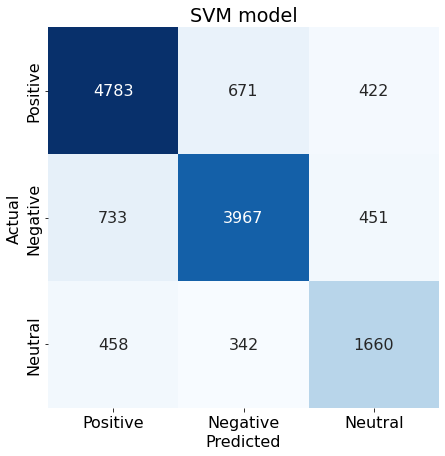

Classification Report 
               precision    recall  f1-score   support

    Positive       0.80      0.81      0.81      5876
    Negative       0.80      0.77      0.78      5151
     Neutral       0.66      0.67      0.66      2460

    accuracy                           0.77     13487
   macro avg       0.75      0.75      0.75     13487
weighted avg       0.77      0.77      0.77     13487



In [ ]:
cm = confusion_matrix(y_test, y_pred, labels = [0,1,2])
clr = classification_report(y_test, y_pred,labels = [0,1,2], target_names = ['Positive', 'Negative', 'Neutral'])
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot = True, fmt = 'g', cbar = False, cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks = [0.5, 1.5, 2.5],labels = ['Positive', 'Negative', 'Neutral'])
plt.yticks(ticks = [0.5, 1.5, 2.5],labels = ['Positive', 'Negative', 'Neutral'])
plt.title('SVM model')
plt.show()
print('Classification Report \n', clr)

# 2 - Naive Bayes Model

### Training

In [ ]:
from sklearn.naive_bayes import MultinomialNB
model2 = MultinomialNB()
model2.fit(features, y_train)

MultinomialNB()

### Accuracy

In [ ]:
print('Model Accuracy : {:.3f}%'.format(model2.score(features_test, y_test)*100))

Model Accuracy : 67.102%


### Confusion Matrix & Classification Report

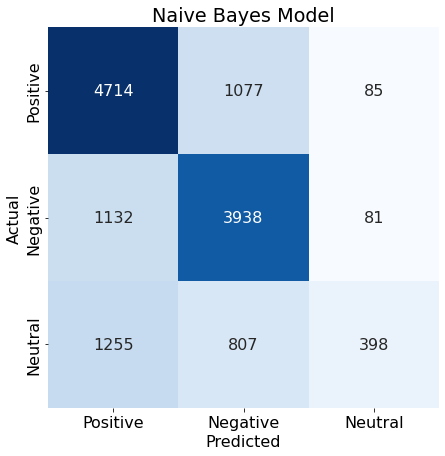

Classification Report 
               precision    recall  f1-score   support

    Positive       0.66      0.80      0.73      5876
    Negative       0.68      0.76      0.72      5151
     Neutral       0.71      0.16      0.26      2460

    accuracy                           0.67     13487
   macro avg       0.68      0.58      0.57     13487
weighted avg       0.68      0.67      0.64     13487



In [ ]:
y_pred = model2.predict(features_test)
cm = confusion_matrix(y_test, y_pred, labels = [0,1,2])
clr = classification_report(y_test, y_pred,labels = [0,1,2], target_names = ['Positive', 'Negative', 'Neutral'])
plt.figure(figsize = (7,7))
sns.heatmap(cm, annot = True, fmt = 'g', cbar = False, cmap = 'Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks(ticks = [0.5, 1.5, 2.5],labels = ['Positive', 'Negative', 'Neutral'])
plt.yticks(ticks = [0.5, 1.5, 2.5],labels = ['Positive', 'Negative', 'Neutral'])
plt.title('Naive Bayes Model')
plt.show()
print('Classification Report \n', clr)